In [7]:
import torch
import torch.nn as nn  # 导入 nn 模块
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import models
import kagglehub  # 导入 kagglehub
import pandas as pd
import torchvision.models as models
import torchvision.transforms as transforms
from albumentations import Normalize
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import accuracy_score
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2

In [3]:
# 下载Stanford Dogs Dataset
path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

# 获取annotations和images的路径
stanford_image_path = f'{path}/images/Images'  # 使用从 kagglehub 下载的路径



# 定义 idx2breed 字典（已经定义）
idx2breed = {0: 'affenpinscher', 1: 'afghan_hound', 2: 'african_hunting_dog', 3: 'airedale', 4: 'american_staffordshire_terrier', 5: 'appenzeller', 6: 'australian_terrier', 7: 'basenji', 8: 'basset', 9: 'beagle', 10: 'bedlington_terrier', 11: 'bernese_mountain_dog', 12: 'black', 13: 'blenheim_spaniel', 14: 'bloodhound', 15: 'bluetick', 16: 'border_collie', 17: 'border_terrier', 18: 'borzoi', 19: 'boston_bull', 20: 'bouvier_des_flandres', 21: 'boxer', 22: 'brabancon_griffon', 23: 'briard', 24: 'brittany_spaniel', 25: 'bull_mastiff', 26: 'cairn', 27: 'cardigan', 28: 'chesapeake_bay_retriever', 29: 'chihuahua', 30: 'chow', 31: 'clumber', 32: 'cocker_spaniel', 33: 'collie', 34: 'curly', 35: 'dandie_dinmont', 36: 'dhole', 37: 'dingo', 38: 'doberman', 39: 'english_foxhound', 40: 'english_setter', 41: 'english_springer', 42: 'entlebucher', 43: 'eskimo_dog', 44: 'flat', 45: 'french_bulldog', 46: 'german_shepherd', 47: 'german_short', 48: 'giant_schnauzer', 49: 'golden_retriever', 50: 'gordon_setter', 51: 'great_dane', 52: 'great_pyrenees', 53: 'greater_swiss_mountain_dog', 54: 'groenendael', 55: 'ibizan_hound', 56: 'irish_setter', 57: 'irish_terrier', 58: 'irish_water_spaniel', 59: 'irish_wolfhound', 60: 'italian_greyhound', 61: 'japanese_spaniel', 62: 'keeshond', 63: 'kelpie', 64: 'kerry_blue_terrier', 65: 'komondor', 66: 'kuvasz', 67: 'labrador_retriever', 68: 'lakeland_terrier', 69: 'leonberg', 70: 'lhasa', 71: 'malamute', 72: 'malinois', 73: 'maltese_dog', 74: 'mexican_hairless', 75: 'miniature_pinscher', 76: 'miniature_poodle', 77: 'miniature_schnauzer', 78: 'newfoundland', 79: 'norfolk_terrier', 80: 'norwegian_elkhound', 81: 'norwich_terrier', 82: 'old_english_sheepdog', 83: 'otterhound', 84: 'papillon', 85: 'pekinese', 86: 'pembroke', 87: 'pomeranian', 88: 'pug', 89: 'redbone', 90: 'rhodesian_ridgeback', 91: 'rottweiler', 92: 'saint_bernard', 93: 'saluki', 94: 'samoyed', 95: 'schipperke', 96: 'scotch_terrier', 97: 'scottish_deerhound', 98: 'sealyham_terrier', 99: 'shetland_sheepdog', 100: 'shih', 101: 'siberian_husky', 102: 'silky_terrier', 103: 'soft', 104: 'staffordshire_bullterrier', 105: 'standard_poodle', 106: 'standard_schnauzer', 107: 'sussex_spaniel', 108: 'tibetan_mastiff', 109: 'tibetan_terrier', 110: 'toy_poodle', 111: 'toy_terrier', 112: 'vizsla', 113: 'walker_hound', 114: 'weimaraner', 115: 'welsh_springer_spaniel', 116: 'west_highland_white_terrier', 117: 'whippet', 118: 'wire', 119: 'yorkshire_terrier'}

# 加载训练好的模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inception = models.inception_v3(pretrained=False, aux_logits=True)
fc_inputs = inception.fc.in_features
inception.fc = nn.Sequential(
    nn.Linear(fc_inputs, 2048),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(2048, 120),  # 假设有120个犬种
    nn.LogSoftmax(dim=1)
)
inception.load_state_dict(torch.load('/content/drive/MyDrive/project2 /inception_finetuningphr.pth', map_location=device))
inception.eval()  # 设置模型为评估模式

# 图像预处理函数
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (299, 299))  # 调整为模型所需的输入大小
    image = image.astype(np.float32) / 255.0  # 归一化到 [0, 1]
    image = np.transpose(image, (2, 0, 1))  # 改变形状为 (C, H, W)
    image = torch.tensor(image).unsqueeze(0)  # 添加批次维度
    return image.to(device)

# 使用模型进行识别
def predict(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        outputs = inception(image_tensor)
        parents_pred = np.argpartition(outputs.detach().numpy(), -2)[:, -2:]  # 选择最可能的两个父母犬种
    return parents_pred

# 获取父母犬种图片的路径
def get_breed_image_path(breed_name, stanford_image_path):
    # 遍历 Stanford Dogs 数据集的图像文件夹，查找对应父母犬种的图像
    for root, dirs, files in os.walk(stanford_image_path):
        for file in files:
            if breed_name.lower() in file.lower():
                return os.path.join(root, file)
    return None




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
<ipython-input-3-c3b8e2646fb3>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the

Predicted Parent 1: doberman
Predicted Parent 2: sussex_spaniel
Trying to load image from: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02107142-Doberman/n02107142_34.jpg
Trying to load image from: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images/n02102480-Sussex_spaniel/n02102480_101.jpg


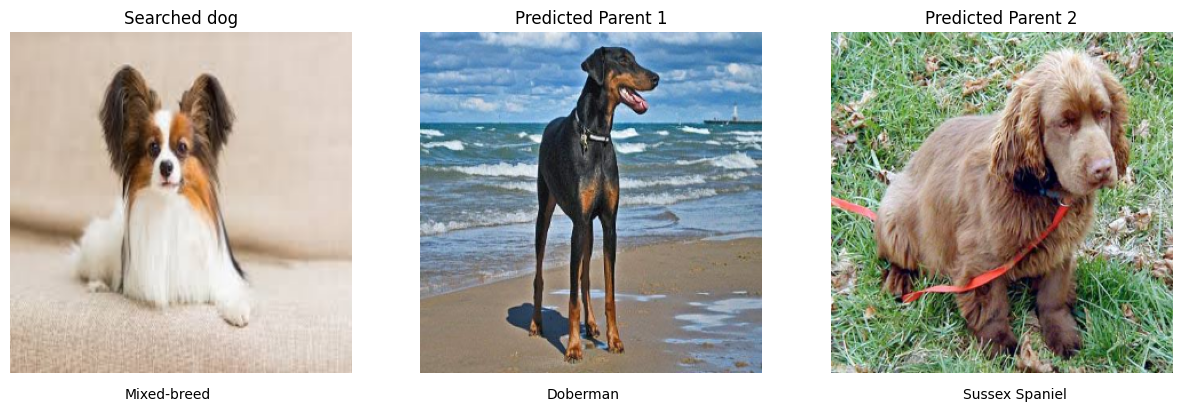

In [15]:
# 设置测试图像文件路径
test_image_path = '/content/pap.jpg'
parents_pred = predict(test_image_path)

# 映射预测结果到犬种名称
parent_breeds = []
for breed_id in parents_pred[0]:
    parent_breeds.append(idx2breed[breed_id])

print(f"Predicted Parent 1: {parent_breeds[0]}")
print(f"Predicted Parent 2: {parent_breeds[1]}")


demo_images = pd.read_csv('/content/drive/MyDrive/project2 /dataset/Project 2 /demo_photos.csv')
parent1_row = demo_images.loc[demo_images['Label'].str.lower() == parent_breeds[0]]
parent2_row = demo_images.loc[demo_images['Label'].str.lower() == parent_breeds[1]]
# 加载和处理测试图像
image1 = cv2.imread(test_image_path)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image1 = cv2.resize(image1, (299, 299))

# 假设您已经提取了 parent1_row 和 parent2_row 的信息
# 加载父母犬种的图像
image2_path = os.path.join(stanford_image_path, parent1_row.Path.values[0][1:])  # 移除开头的斜杠
print(f"Trying to load image from: {image2_path}")
image2 = cv2.imread(image2_path)

if image2 is None:
    print(f"Error: Image not found or cannot be loaded at {image2_path}")
else:
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    image2 = cv2.resize(image2, (299, 299))

image3_path = os.path.join(stanford_image_path, parent2_row.Path.values[0][1:])  # 移除开头的斜杠
print(f"Trying to load image from: {image3_path}")
image3 = cv2.imread(image3_path)

if image3 is None:
    print(f"Error: Image not found or cannot be loaded at {image3_path}")
else:
    image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
    image3 = cv2.resize(image3, (299, 299))

# 可视化结果
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Searched dog')
plt.axis('off')
plt.text(100, 320, 'Mixed-breed')

plt.subplot(1, 3, 2)
if image2 is not None:  # 只在 image2 成功加载的情况下显示
    plt.imshow(image2)
    plt.title('Predicted Parent 1')
    plt.axis('off')
    plt.text(110, 320, parent1_row.Name.values[0])

plt.subplot(1, 3, 3)
if image3 is not None:  # 只在 image3 成功加载的情况下显示
    plt.imshow(image3)
    plt.title('Predicted Parent 2')
    plt.axis('off')
    plt.text(115, 320, parent2_row.Name.values[0])

plt.show()